In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۶: مبانی مهندسی ویژگی (Feature Engineering)

مهندسی ویژگی، هنر و مهارتِ تبدیل *سیگنال‌های خام* به *ورودی‌های مناسب برای مدل* است؛ به‌گونه‌ای که ساختار مسئله را بهتر آشکار کند. در یادگیری ماشین جدولی (Tabular)، در بسیاری از پروژه‌های واقعی، بخش بزرگی از بهبودِ عملکرد، پایداری و تفسیرپذیری دقیقاً از همین مرحله به‌دست می‌آید.

یک بیان فشرده از ایده:

- ورودی خام: $x_{\mathrm{raw}}$
- نگاشت ویژگی: $\phi(\cdot)$
- پیش‌بینی مدل: $$\hat{y} = f_{\theta}\!\left(\phi(x_{\mathrm{raw}})\right)$$

حتی اگر در نهایت از یادگیرنده‌های قدرتمند استفاده کنید، یک $\phi(\cdot)$ خوب می‌تواند یادگیری را ساده‌تر کند، نیاز به داده را کاهش دهد، و از خطاهای رایج (به‌ویژه نشت اطلاعات یا Leakage) جلوگیری کند.

### خروجی‌های عملی این درس
در پایان این درس می‌توانید:

1. تشخیص دهید کدام تبدیل‌های ویژگی، *کلاس فرضیه* (و بنابراین ظرفیت مدل) را تغییر می‌دهند.
2. برای ویژگی‌های عددی، دسته‌ای، زمانی، متنی و تجمیع‌های گروهی، ویژگی‌های مفید بسازید و بهداشت Train/Test را رعایت کنید.
3. الگوهای نشت اطلاعات را شناسایی و از آن‌ها جلوگیری کنید.
4. یک پایپ‌لاین انتهابه‌انتها با `scikit-learn` بسازید که مراحل مهندسی ویژگی را بازتولیدپذیر و امن نگه دارد.
5. ارزیابی کنید آیا ویژگی‌های ساخته‌شده واقعاً کمک می‌کنند یا فقط پیچیدگی اضافه می‌کنند.

برای تمرین انتخاب ویژگی (نه حفظ کردن یک دستورالعمل ثابت)، تکنیک‌ها را روی **چندین دیتاست** (طبقه‌بندی، رگرسیون، و داده‌های ترکیبی) نشان می‌دهیم.


## ۱) یک مدل ذهنی: ویژگی‌ها تعیین می‌کنند مدل چه چیزی را می‌تواند نمایش دهد

وقتی خانوادهٔ مدل را انتخاب می‌کنید، در واقع یک *کلاس فرضیه* انتخاب کرده‌اید. اما مهندسی ویژگی می‌تواند به همان اندازه مهم باشد؛ چون “زبانی” که مدل با آن داده را می‌بیند را عوض می‌کند.

برای مثال، یک مدل خطی روی ویژگی‌های مهندسی‌شده:

$$\hat{y} = w^\top \phi(x) + b$$

حتی اگر $w$ خطی باشد، $\phi(\cdot)$ می‌تواند با روش‌های مختلف، غیرخطی‌بودن را وارد کند؛ مانند:
- ضرب‌ها ($x_1 x_2$)،
- نسبت‌ها ($x_1/(x_2+\epsilon)$)،
- چندجمله‌ای‌ها ($x_1^2$)،
- بین‌بندی/باکتی‌کردن (Bucketization)،
- لگاریتم ($\log(1+x)$)،
- و موارد دیگر.

### سه سؤال عملی قبل از مهندسی ویژگی
1. **چه ناوردایی‌هایی (Invariance) باید رعایت شوند؟** (مثلاً ناوردایی نسبت به مقیاس → نسبت‌ها/لگ)
2. **چه روابط یکنواخت یا ساختاری محتمل است؟** (مثلاً افزایش ریسک با افزایش دوز)
3. **نشت اطلاعات احتمالاً کجا پنهان می‌شود؟** (مثلاً متغیرهای پس از رخداد، تجمیع‌های آینده)

در ادامه، این سؤال‌ها را مثل یک چک‌لیست هنگام ساخت ویژگی‌ها به‌کار می‌بریم.


## ۲) یک ویژگی مهندسی‌شده «خوب» چه ویژگی‌هایی دارد؟

یک ویژگی مهندسی‌شدهٔ مفید معمولاً حداقل یکی از این خواص را دارد:

- **پیش‌بین**: با هدف هم‌بستگی دارد چون یک جانشین علّی یا یک ارتباط پایدار را می‌گیرد.
- **پایدار**: نسبت به نویز، پرت‌ها یا دسته‌های نادر بیش از حد حساس نیست.
- **قابل محاسبه در زمان استنتاج**: در زمان Deploy واقعاً می‌توانید آن را از اطلاعات موجود حساب کنید.
- **ریسک نشت پایین**: سیگنال‌های پس از رخداد یا تجمیع‌هایی که از دادهٔ آینده استفاده می‌کنند را قاچاقی وارد نمی‌کند.
- **هزینهٔ عملیاتی پایین**: شکننده، پرهزینه یا سخت‌نگهداری نباشد.
- **هم‌راستا با مدل**: با نقاط قوت خانوادهٔ مدل سازگار است (مثلاً مدل خطی روابط «تقریباً خطی» را دوست دارد).

یک نگاه عملی: مهندسی ویژگی، مذاکره‌ای بین *ساختار دامنه* و *بایاس مدل* است.

### نمونه‌هایی از انتخاب‌های «هم‌راستا با مدل»
- برای مدل‌های خطی/GLM: تبدیل‌های لگ، نسبت‌ها، تعامل‌ها، پارامترسازی‌های یکنواخت.
- برای درخت‌ها: بین‌بندی کمتر ضروری است، اما شاخص‌های Missing و تقسیم‌های معنی‌دار کمک می‌کنند.
- برای مدل‌های مبتنی بر فاصله (kNN، کرنل RBF): اسکیل کردن و «یادگیری متریک با ویژگی‌ها» حیاتی است.
- برای Naive Bayes/مدل‌های شمارشی: شمارش‌ها، نرخ‌ها و گسسته‌سازی‌های کالیبره‌شده فرض‌ها را ساده‌تر می‌کنند.


## ۳) داده‌هایی که در این درس استفاده می‌کنیم

برای تمرینِ *انتخاب ویژگی*، چند جدول با شکل و شمایل واقعی را بررسی می‌کنیم:

- **سلامت / طبقه‌بندی** (سبک دیتاست دیابت با اندازه‌گیری‌های عددی)
- **تجارت الکترونیک / رگرسیون** (الماس‌ها با ویژگی‌های دسته‌ای کیفیت + ویژگی‌های عددی)
- **مسکن / رگرسیون** (قیمت خانه با ساختار محله)
- **جغرافیا + متن** (فست‌فودها با دسته‌بندی متنی + عرض/طول جغرافیایی)
- **رخدادهای زمانی** (زمان‌سنجی زلزله‌ها)
- **آگهی‌ها/لیستینگ‌ها** (ساختار گروهی: محله‌ها، میزبان‌ها)
- **جدول سبک منابع انسانی** (حقوق با عنوان شغلی)

در پروژهٔ واقعی معمولاً مهندسی ویژگی را روی فایل‌های CSV کامل مخزن انجام می‌دهید. در اینجا برای خوانایی، از چند ردیف نمونه استفاده می‌کنیم و برای اینکه ارزیابی مدل معنی‌دار شود، با نمونه‌گیری مجدد + نویز، جداول *اسباب‌بازی* بزرگ‌تری می‌سازیم.


## ۴) آماده‌سازی

از ابزارهای زیر استفاده می‌کنیم:
- `pandas` / `numpy` برای کار با جدول‌ها،
- `scikit-learn` برای پیش‌پردازش، پایپ‌لاین و ارزیابی.

برای بازتولیدپذیری مثال‌ها، بذر تصادفی را ثابت می‌کنیم.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, PolynomialFeatures,
    PowerTransformer, QuantileTransformer, KBinsDiscretizer,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import matplotlib.pyplot as plt

np.random.seed(7)

In [3]:
# Load datasets from the repository paths (if present). Otherwise use small embedded excerpts.

from pathlib import Path

def load_csv_or_fallback(path, fallback_df):
    p = Path(path)
    if p.exists():
        return pd.read_csv(p)
    return fallback_df.copy()

diabetes_fallback = pd.DataFrame([
    [6,148,72,35,0,33.6,0.627,50,"Diabetic"],
    [1,85,66,29,0,26.6,0.351,31,"Non-Diabetic"],
    [8,183,64,0,0,23.3,0.672,32,"Diabetic"],
    [1,89,66,23,94,28.1,0.167,21,"Non-Diabetic"],
    [0,137,40,35,168,43.1,2.288,33,"Diabetic"],
], columns=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","classification"])

diamonds_fallback = pd.DataFrame([
    [1,0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43],
    [2,0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31],
    [3,0.23,"Good","E","VS1",56.9,65,327,4.05,4.07,2.31],
    [4,0.29,"Premium","I","VS2",62.4,58,334,4.20,4.23,2.63],
    [5,0.31,"Good","J","SI2",63.3,58,335,4.34,4.35,2.75],
    [6,0.24,"Very Good","J","VVS2",62.8,57,336,3.94,3.96,2.48],
], columns=["id","carat","cut","color","clarity","depth","table","price","x","y","z"])

house_prices_fallback = pd.DataFrame([
    [1,114300,1790,2,2,2,"No","East"],
    [2,114200,2030,4,2,3,"No","East"],
    [3,114800,1740,3,2,1,"No","East"],
    [4,94700,1980,3,2,3,"No","East"],
    [5,119800,2130,3,3,3,"No","East"],
], columns=["Home","Price","SqFt","Bedrooms","Bathrooms","Offers","Brick","Neighborhood"])

salaries_fallback = pd.DataFrame([
    ["Kevin Sanders",24,"Software Engineer",7300],
    ["Lisa Mills",26,"High School Teacher",6100],
    ["Donna Allison",27,"Dentist",12700],
    ["Michael Schmitt",43,"Dentist",17500],
    ["Lisa Shaffer",31,"Accountant",7400],
], columns=["Name","Age","Job","Salary"])

fast_food_fallback = pd.DataFrame([
    [0,"800 N Canal Blvd","American Restaurant and Fast Food Restaurant","Thibodaux","US",29.814697,-90.814742,"SONIC Drive In","70301","LA",
     "https://locations.sonicdrivein.com/la/thibodaux/800-north-canal-boulevard.html,http://sonicdrivein.com,http://www.sonicdrivein.com"],
    [1,"800 N Canal Blvd","Fast Food Restaurants","Thibodaux","US",29.814697,-90.814742,"SONIC Drive In","70301","LA",
     "https://locations.sonicdrivein.com/la/thibodaux/800-north-canal-boulevard.html,http://sonicdrivein.com,http://www.sonicdrivein.com"],
    [2,"206 Wears Valley Rd","Fast Food Restaurant","Pigeon Forge","US",35.803788,-83.580553,"Taco Bell","37863","TN",
     "http://www.tacobell.com,https://locations.tacobell.com/tn/pigeon-forge/206-wears-valley-road.html"],
    [3,"3652 Parkway","Fast Food","Pigeon Forge","US",35.782339,-83.551408,"Arby's","37863","TN",
     "http://www.arbys.com,https://locations.arbys.com/us/tn/pigeon-forge/3652-parkway.html"],
    [4,"2118 Mt Zion Parkway","Fast Food Restaurant","Morrow","US",33.562738,-84.321143,"Steak 'n Shake","30260","GA",
     "http://www.steaknshake.com/locations/23851-steak-n-shake-mt-zion-parkway-morrow"],
    [5,"9768 Grand River Ave","Fast Food Restaurant","Detroit","US",42.368823,-83.138251,"Wendy's","48204","MI",
     "http://www.wendys.com"],
], columns=["idx","address","categories","city","country","latitude","longitude","name","postalCode","province","websites"])

earthquake_fallback = pd.DataFrame([
    ["2008-11-01","00:31:25",-0.6,98.89553,20.0,2.99],
    ["2008-11-01","01:34:29",-6.61,129.38722,30.1,5.51],
    ["2008-11-01","01:38:14",-3.65,127.99068,5.0,3.54],
    ["2008-11-01","02:20:05",-4.2,128.097,5.0,2.42],
    ["2008-11-01","02:32:18",-4.09,128.20047,10.0,2.41],
], columns=["date","time","latitude","longitude","depth","magnitude"])

listings_fallback = pd.DataFrame([
    [13913,"Holiday London DB Room Let-on going",54730,"Alina",None,"Islington",51.56861,-0.1127,"Private room",57,1,51,"2025-02-09",0.29,3,344,10,None],
    [15400,"Bright Chelsea  Apartment. Chelsea!",60302,"Philippa",None,"Kensington and Chelsea",51.4878,-0.16813,"Entire home/apt",np.nan,4,96,"2024-04-28",0.52,1,11,2,None],
    [17402,"Very Central Modern 3-Bed/2 Bath By Oxford St W1",67564,"Liz",None,"Westminster",51.52195,-0.14094,"Entire home/apt",510,3,56,"2024-02-19",0.33,5,293,0,None],
    [24328,"Battersea live/work artist house",41759,"Joe",None,"Wandsworth",51.47072,-0.16266,"Entire home/apt",213,90,94,"2022-07-19",0.54,1,194,0,None],
    [31036,"Bright  compact 1 Bedroom Apartment Brick Lane",133271,"Hendryks",None,"Tower Hamlets",51.52425,-0.06997,"Entire home/apt",100,2,126,"2025-02-20",0.70,8,353,3,None],
], columns=[
    "id","name","host_id","host_name","neighbourhood_group","neighbourhood",
    "latitude","longitude","room_type","price","minimum_nights","number_of_reviews",
    "last_review","reviews_per_month","calculated_host_listings_count","availability_365",
    "number_of_reviews_ltm","license"
])

diabetes = load_csv_or_fallback("../../../Datasets/Classification/diabetes.csv", diabetes_fallback)
diamonds = load_csv_or_fallback("../../../Datasets/Regression/diamonds.csv", diamonds_fallback)
house_prices = load_csv_or_fallback("../../../Datasets/Regression/house-prices.csv", house_prices_fallback)
salaries = load_csv_or_fallback("../../../Datasets/Regression/salaries.csv", salaries_fallback)
fast_food = load_csv_or_fallback("../../../Datasets/Classification/Fast_Food_Restaurants_US.csv", fast_food_fallback)
earthquake = load_csv_or_fallback("../../../Datasets/Regression/earthquake.csv", earthquake_fallback)
listings = load_csv_or_fallback("../../../Datasets/Regression/listings.csv", listings_fallback)

diabetes.head(), diamonds.head(), house_prices.head(), salaries.head()

(   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age classification  
 0                     0.627   50       Diabetic  
 1                     0.351   31   Non-Diabetic  
 2                     0.672   32       Diabetic  
 3                     0.167   21   Non-Diabetic  
 4                     2.288   33       Diabetic  ,
    id  carat      cut color clarity  depth  table  price     x     y     z
 0   1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
 1   2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
 2   3   0.23     Good   

## ۵) مهندسی ویژگی عددی: فراتر از «فقط اسکیل کردن»

مهندسی ویژگی عددی معمولاً یکی از مشکلات زیر را هدف می‌گیرد:

1. **چولگی و دم‌های سنگین** → استفاده از $\log(1+x)$، تبدیل‌های توانی، تبدیل‌های کوانتیلی.
2. **تعامل‌های غیرخطی** → نسبت‌ها، ضرب‌ها، چندجمله‌ای‌ها.
3. **کمبود داده پنهان** → شاخص‌های Missing، مقادیر Sentinel (با احتیاط!) و ایمپیوت درست با توجه به دامنه.
4. **رزولوشن و نویز** → هموارسازی، گرد کردن، برش/Winsorization.
5. **اثر آستانه‌ای** → بین‌بندی یا ویژگی‌های قطعه‌ای.

نکتهٔ کلیدی: پارامترهای تبدیل باید فقط از دادهٔ آموزش برآورد شوند. اگر مثلاً تبدیل کوانتیلی را با کل داده بسازید، اطلاعاتی از توزیع تست به آموزش نشت می‌کند.


In [4]:
df = diabetes.copy()

zero_as_missing_cols = ["SkinThickness", "Insulin"]
for c in zero_as_missing_cols:
    df[f"{c}_is_zero"] = (df[c] == 0).astype(int)
    df[c] = df[c].replace(0, np.nan)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification,SkinThickness_is_zero,Insulin_is_zero
0,6,148,72,35.0,NaN,33.6,0.627,50,Diabetic,0,1
1,1,85,66,29.0,NaN,26.6,0.351,31,Non-Diabetic,0,1
2,8,183,64,NaN,NaN,23.3,0.672,32,Diabetic,1,1
3,1,89,66,23.0,94.0,28.1,0.167,21,Non-Diabetic,0,0
4,0,137,40,35.0,168.0,43.1,2.288,33,Diabetic,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48.0,180.0,32.9,0.171,63,Non-Diabetic,0,0
764,2,122,70,27.0,NaN,36.8,0.340,27,Non-Diabetic,0,1
765,5,121,72,23.0,112.0,26.2,0.245,30,Non-Diabetic,0,0
766,1,126,60,NaN,NaN,30.1,0.349,47,Diabetic,1,1


In [5]:
df_imputed = df.copy()
for c in ["SkinThickness", "Insulin"]:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

df_imputed["BMI_log1p"] = np.log1p(df_imputed["BMI"])

pt = PowerTransformer(method="yeo-johnson", standardize=False)
df_imputed[["Insulin_yj"]] = pt.fit_transform(df_imputed[["Insulin"]])

df_imputed[["BMI","BMI_log1p","Insulin","Insulin_yj","SkinThickness_is_zero","Insulin_is_zero"]]

,BMI,BMI_log1p,Insulin,Insulin_yj,SkinThickness_is_zero,Insulin_is_zero
0,33.6,3.543854,125.0,5.501640,0,1
1,26.6,3.317816,125.0,5.501640,0,1
2,23.3,3.190476,125.0,5.501640,1,1
3,28.1,3.370738,94.0,5.140788,0,0
4,43.1,3.786460,168.0,5.882504,0,0
...,...,...,...,...,...,...
763,32.9,3.523415,180.0,5.972330,0,0
764,36.8,3.632309,125.0,5.501640,0,1
765,26.2,3.303217,112.0,5.361867,0,0
766,30.1,3.437208,125.0,5.501640,1,1


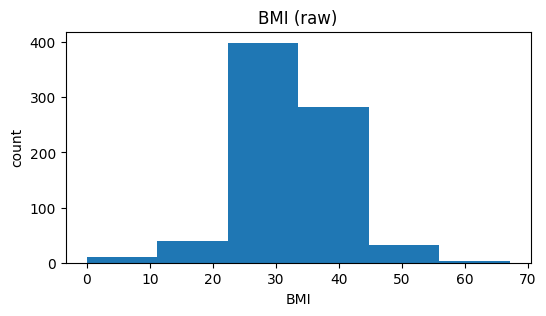

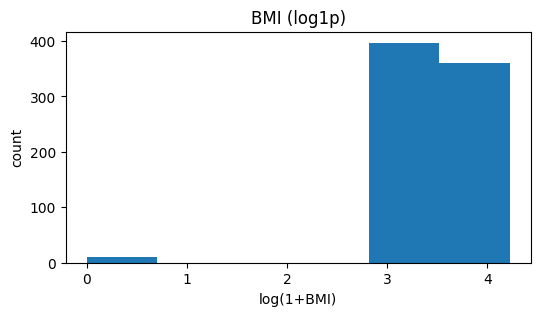

In [6]:
x = df_imputed["BMI"].to_numpy()
x_log = df_imputed["BMI_log1p"].to_numpy()

plt.figure(figsize=(6,3))
plt.hist(x, bins=6)
plt.title("BMI (raw)")
plt.xlabel("BMI"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(x_log, bins=6)
plt.title("BMI (log1p)")
plt.xlabel("log(1+BMI)"); plt.ylabel("count")
plt.show()

### ۵.۱) تبدیل کوانتیلی/رتبه‌ای (وقتی مدل خطی مشکل دارد)

اگر یک ویژگی عددی بسیار چوله باشد، مدل خطی ممکن است ظرفیت خود را صرفِ دنبالهٔ توزیع کند و روند مرکزی را بدتر یاد بگیرد. تبدیل کوانتیلی، توزیع تجربی را به یک توزیع هدف (معمولاً یکنواخت یا نرمال) نگاشت می‌کند.

به‌صورت مفهومی:
- $F(x)$ را CDF تجربی ویژگی در نظر بگیرید.
- تبدیل برابر است با $x' = F(x)$ (یکنواخت) یا $x' = \Phi^{-1}(F(x))$ (نرمال).

این روش قدرتمند است، اما باید فقط روی دادهٔ آموزش Fit شود (چون به توزیع تجربی وابسته است).


In [7]:
rng = np.random.default_rng(0)

skewed = pd.Series(rng.lognormal(mean=1.0, sigma=1.0, size=1200), name="skewed")

qt = QuantileTransformer(output_distribution="normal", random_state=0)
skewed_q = qt.fit_transform(skewed.to_frame())[:,0]

pd.DataFrame({
    "raw_mean": [float(skewed.mean())],
    "raw_std": [float(skewed.std())],
    "raw_min": [float(skewed.min())],
    "raw_max": [float(skewed.max())],
    "qt_mean": [float(np.mean(skewed_q))],
    "qt_std": [float(np.std(skewed_q))],
    "qt_min": [float(np.min(skewed_q))],
    "qt_max": [float(np.max(skewed_q))],
})

,raw_mean,raw_std,raw_min,raw_max,qt_mean,qt_std,qt_min,qt_max
0,4.217466,5.113133,0.055055,58.325345,-0.000072,1.016717,-5.199338,5.199338


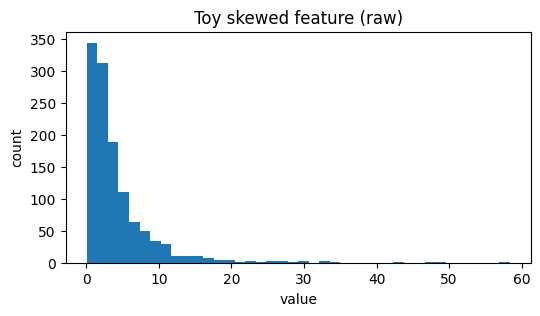

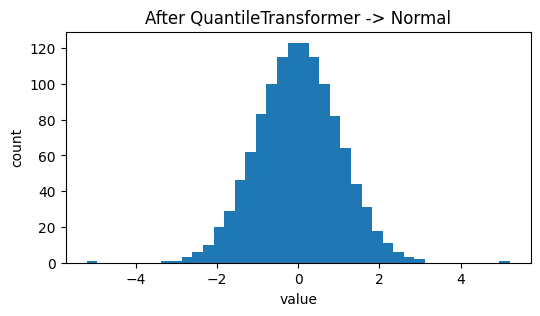

In [8]:
plt.figure(figsize=(6,3))
plt.hist(skewed, bins=40)
plt.title("Toy skewed feature (raw)")
plt.xlabel("value"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(skewed_q, bins=40)
plt.title("After QuantileTransformer -> Normal")
plt.xlabel("value"); plt.ylabel("count")
plt.show()

### ۵.۲) بین‌بندی و ویژگی‌های قطعه‌ای (اثر آستانه‌ای)

گاهی در دنیای واقعی آستانه وجود دارد:
- «ریسک بالا» بالاتر از یک سطح گلوکز،
- «پریمیوم» بالاتر از یک حد اندازه،
- «ساعت شلوغی» در بازه‌های زمانی مشخص.

یک راه ساده برای گرفتن آستانه‌ها در مدل خطی، گسسته‌سازی متغیر پیوسته به چند بین (Bin) است. وقتی بین‌ها را One-Hot می‌کنید، مدل می‌تواند برای هر بازه یک آفست متفاوت یاد بگیرد (تقریب قطعه‌ایِ ثابت).

بین‌بندی برای این موارد هم مفید است:
- تفسیرپذیری (بین‌ها با قواعد انسانی هم‌راستا هستند)،
- مقاوم‌سازی در برابر پرت‌ها،
- و قیود یکنوایی (اگر بعداً بخواهید اعمال کنید).

بین‌بندی را با `KBinsDiscretizer` نشان می‌دهیم.


In [9]:
ages = df_imputed[["Age"]].copy()

kb = KBinsDiscretizer(n_bins=4, encode="onehot-dense", strategy="quantile")
age_bins = kb.fit_transform(ages)

bin_cols = [f"Age_bin_{i}" for i in range(age_bins.shape[1])]
age_bins_df = pd.DataFrame(age_bins, columns=bin_cols)

pd.concat([df_imputed[["Age"]], age_bins_df], axis=1)

,Age,Age_bin_0,Age_bin_1,Age_bin_2,Age_bin_3
0,50,0.0,0.0,0.0,1.0
1,31,0.0,0.0,1.0,0.0
2,32,0.0,0.0,1.0,0.0
3,21,1.0,0.0,0.0,0.0
4,33,0.0,0.0,1.0,0.0
...,...,...,...,...,...
763,63,0.0,0.0,0.0,1.0
764,27,0.0,1.0,0.0,0.0
765,30,0.0,0.0,1.0,0.0
766,47,0.0,0.0,0.0,1.0


## ۶) تعامل‌ها و «فیزیک» در یادگیری ماشین جدولی

در بسیاری از حوزه‌ها، *نسبت* یا *حاصل‌ضرب* اندازه‌گیری‌ها از خود مقدار خام معنی‌دارتر است:
- ریسک به غلظت بر واحد حجم وابسته است،
- توان به گشتاور × سرعت زاویه‌ای وابسته است،
- چگالی برابر است با جرم / حجم.

این‌ها ترفندهای تصادفی نیستند؛ بلکه فرضیه‌های دامنه را در $\phi(\cdot)$ کدنویسی می‌کنند.

یک آزمایش کنترل‌شده نشان می‌دهیم که برچسب واقعی به یک ویژگی تعاملی وابسته است. مدل خطی بدون آن تعامل مجبور به تقریب است؛ با اضافه کردن تعامل، «سیستم مختصات» درست به مدل داده می‌شود.


In [10]:
feat = df_imputed.copy()
eps = 1e-6

feat["Glucose_over_BMI"] = feat["Glucose"] / (feat["BMI"] + eps)
feat["Age_times_BMI"] = feat["Age"] * feat["BMI"]

feat[["Glucose","BMI","Glucose_over_BMI","Age","Age_times_BMI","classification"]]

,Glucose,BMI,Glucose_over_BMI,Age,Age_times_BMI,classification
0,148,33.6,4.404762,50,1680.0,Diabetic
1,85,26.6,3.195489,31,824.6,Non-Diabetic
2,183,23.3,7.854077,32,745.6,Diabetic
3,89,28.1,3.167260,21,590.1,Non-Diabetic
4,137,43.1,3.178654,33,1422.3,Diabetic
...,...,...,...,...,...,...
763,101,32.9,3.069909,63,2072.7,Non-Diabetic
764,122,36.8,3.315217,27,993.6,Non-Diabetic
765,121,26.2,4.618320,30,786.0,Non-Diabetic
766,126,30.1,4.186046,47,1414.7,Diabetic


In [11]:
rng = np.random.default_rng(3)

base = diabetes.drop(columns=["classification"]).copy()
diab_big = base.sample(4500, replace=True, random_state=3).reset_index(drop=True)

for c, s in zip(diab_big.columns, [1.2, 20, 10, 12, 90, 5, 0.35, 12]):
    diab_big[c] = (diab_big[c].astype(float) + rng.normal(0, s, len(diab_big))).clip(lower=0)

score = (
    0.04 * diab_big["Glucose"]
    - 0.015 * diab_big["BloodPressure"]
    + 0.008 * (diab_big["Age"] * diab_big["BMI"])
    + 1.6 * (diab_big["Glucose"] / (diab_big["BMI"] + 1e-6))
    + rng.normal(0, 2.5, len(diab_big))
)
y = (score > np.quantile(score, 0.55)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(diab_big, y, test_size=0.25, random_state=3, stratify=y)

baseline = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
baseline.fit(X_train, y_train)

auc_base = roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1])
acc_base = accuracy_score(y_test, baseline.predict(X_test))

def add_diabetes_features(df: pd.DataFrame) -> np.ndarray:
    X = df.copy()
    eps = 1e-6
    return np.column_stack([
        X["Pregnancies"].to_numpy(),
        X["Glucose"].to_numpy(),
        X["BloodPressure"].to_numpy(),
        X["SkinThickness"].to_numpy(),
        X["Insulin"].to_numpy(),
        X["BMI"].to_numpy(),
        X["DiabetesPedigreeFunction"].to_numpy(),
        X["Age"].to_numpy(),
        (X["Glucose"] / (X["BMI"] + eps)).to_numpy(),
        (X["Age"] * X["BMI"]).to_numpy(),
    ])

engineered = Pipeline([
    ("feat", FunctionTransformer(add_diabetes_features, validate=False)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])
engineered.fit(X_train, y_train)

auc_eng = roc_auc_score(y_test, engineered.predict_proba(X_test)[:,1])
acc_eng = accuracy_score(y_test, engineered.predict(X_test))

pd.DataFrame({
    "model": ["baseline (raw)", "engineered (ratio + product)"],
    "accuracy": [acc_base, acc_eng],
    "roc_auc": [auc_base, auc_eng]
})

,model,accuracy,roc_auc
0,baseline (raw),0.845333,0.932637
1,engineered (ratio + product),0.864889,0.946078


## ۷) مهندسی ویژگی‌های دسته‌ای: ساختار، کم‌یابی و کاردینالیتی بالا

ویژگی‌های دسته‌ای می‌توانند سیگنال بسیار قوی داشته باشند، اما دام‌های مهمی هم دارند:

- **کاردینالیتی بالا** (تعداد زیاد دسته‌های یکتا) اگر همه‌چیز را One-Hot کنید، ابعاد را انفجاری می‌کند.
- **دسته‌های نادر** می‌توانند وزن‌های ناپایدار بسازند.
- **ناهمگونی نوشتاری** (حروف کوچک/بزرگ، املای متفاوت) می‌تواند سیگنال را تکه‌تکه کند (مثلاً `"NYC"` در برابر `"New York"`).
- **نشت هدف** ممکن است رخ دهد اگر دسته‌ها را با آمار برچسب روی کل داده کدگذاری کنید.

راهبردهای رایج:
1. **One-Hot** (امن و یک خط پایهٔ قوی).
2. **ادغام دسته‌های نادر**: دسته‌های کم‌تعداد را در `"Other"` جمع کنید.
3. **کدگذاری فراوانی/شمارش**: جایگزینی دسته با فراوانی آن در آموزش.
4. **ترفند هش**: نگاشت رشته‌ها به فضای ثابت (برای مقیاس بزرگ مفید است).
5. **Target Encoding**: قدرتمند، اما باید داخل Foldهای Cross-Validation انجام شود تا نشت رخ ندهد.

الگوهای امنِ One-Hot و Frequency Encoding را نشان می‌دهیم.


In [12]:
rng = np.random.default_rng(10)
ff_big = fast_food.sample(700, replace=True, random_state=10).reset_index(drop=True)

ff_big["city"] = ff_big["city"].astype(str)
mask = rng.random(len(ff_big)) < 0.25
ff_big.loc[mask, "city"] = ff_big.loc[mask, "city"].str.upper()

text = (ff_big["name"].fillna("") + " " + ff_big["categories"].fillna("")).str.lower()
y = ((ff_big["city"].str.lower().isin(["detroit"])) | text.str.contains("taco")).astype(int)

X_train, X_test, y_train, y_test = train_test_split(ff_big, y, test_size=0.25, random_state=10, stratify=y)

freq = X_train["city"].str.lower().value_counts(normalize=True)
global_freq = float(freq.mean())

Xtr = X_train.copy()
Xte = X_test.copy()

Xtr["city_freq"] = Xtr["city"].str.lower().map(freq).fillna(global_freq)
Xte["city_freq"] = Xte["city"].str.lower().map(freq).fillna(global_freq)

m0 = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m0.fit(Xtr[["city_freq"]], y_train)

auc = roc_auc_score(y_test, m0.predict_proba(Xte[["city_freq"]])[:,1])
pd.DataFrame({"roc_auc_using_city_freq_only":[auc], "n_train":[len(X_train)], "n_test":[len(X_test)]})

,roc_auc_using_city_freq_only,n_train,n_test
0,0.574228,525,175


## ۸) ویژگی‌های زمانی، چرخه‌ای، و مشتق‌شده از رخداد

زمان خاص است چون:
- یک **ترتیب** القا می‌کند،
- اغلب **فصل‌مندی/چرخه** دارد (چرخه‌های روزانه/هفتگی/سالانه)،
- و به‌راحتی می‌تواند اطلاعات «آینده» را نشت دهد.

ویژگی‌های مفید زمانی شامل:
- بخش‌های تقویمی (سال، ماه، روز هفته، ساعت)،
- زمان سپری‌شده از یک مبدأ،
- کدگذاری چرخه‌ای: $$\sin\!\left(2\pi t/T\right),\ \cos\!\left(2\pi t/T\right)$$
- و لگ‌ها/میانگین‌های لغزان (برای مسائل سری‌زمانی واقعی؛ در فصل‌های بعدی عمیق‌تر بررسی می‌شود)

یک مثال جمع‌وجور با زمان‌سنجی زلزله‌ها می‌سازیم.


In [13]:
rng = np.random.default_rng(5)

hp = house_prices.sample(3500, replace=True, random_state=5).reset_index(drop=True)

# Add variation
hp["SqFt"] = (hp["SqFt"] + rng.normal(0, 180, len(hp))).clip(lower=800)
hp["Bedrooms"] = (hp["Bedrooms"] + rng.integers(-1, 2, len(hp))).clip(lower=1, upper=6)
hp["Bathrooms"] = (hp["Bathrooms"] + rng.integers(0, 2, len(hp))).clip(lower=1, upper=4)
hp["Offers"] = (hp["Offers"] + rng.integers(-1, 2, len(hp))).clip(lower=0, upper=6)

# Create a neighborhood interaction: effect of SqFt depends on Neighborhood
neigh_mult = hp["Neighborhood"].map({"East": 55, "North": 65, "West": 50, "South": 45}).fillna(55)
brick_bonus = (hp["Brick"].astype(str).str.lower() == "yes").astype(int) * 9000

price = (
    25000
    + neigh_mult * hp["SqFt"]
    + 8500 * hp["Bedrooms"]
    + 12000 * hp["Bathrooms"]
    + 1500 * hp["Offers"]
    + brick_bonus
    + rng.normal(0, 12000, len(hp))
)
hp["Price_true"] = price

X = hp.drop(columns=["Home","Price","Price_true"])
y = hp["Price_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

num_cols = ["SqFt","Bedrooms","Bathrooms","Offers"]
cat_cols = ["Brick","Neighborhood"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred0 = baseline.predict(X_test)

# Engineered interaction: SqFt * (Neighborhood one-hot) via polynomial on scaled SqFt + one-hot Neighborhood
# Here we explicitly add SqFt x Neighborhood as separate numeric features.
def add_hp_interactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for neigh in df["Neighborhood"].dropna().unique():
        df[f"SqFt_x_neigh_{neigh}"] = df["SqFt"] * (df["Neighborhood"] == neigh).astype(int)
    return df

engineered = Pipeline([
    ("feat", FunctionTransformer(add_hp_interactions, validate=False)),
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols + [c for c in X.columns if c.startswith("SqFt_x_neigh_")]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ], remainder="drop")),
    ("model", Ridge(alpha=1.0))
])

engineered.fit(X_train, y_train)
pred1 = engineered.predict(X_test)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

pd.DataFrame({
    "model": ["baseline", "engineered (SqFt×Neighborhood)"],
    "R2": [r2_score(y_test, pred0), r2_score(y_test, pred1)],
    "RMSE": [rmse(y_test, pred0), rmse(y_test, pred1)]
})

,model,R2,RMSE
0,baseline,0.792888,12014.564433
1,engineered (SqFt×Neighborhood),0.792888,12014.564433


## ۹) متن و رشته‌های نیمه‌ساخت‌یافته به‌عنوان ویژگی

بسیاری از دیتاست‌های «جدولی» ستون‌های متنی دارند:
- نام‌ها، دسته‌ها، برچسب‌ها،
- توضیحات آزاد،
- URLها و شناسه‌ها.

یک روش پایه، توکن‌سازی + Bag-of-Words یا TF-IDF است. مهندسی ویژگی در اینجا شامل:
- انتخاب اینکه کدام ستون‌های متنی را با هم ادغام کنیم،
- نرمال‌سازی توکن‌ها (حروف کوچک، حذف علائم نگارشی)،
- و محدود کردن واژگان برای کاهش نویز.

از دسته‌بندی فست‌فودها ویژگی‌های متنی ساده استخراج می‌کنیم و آمار واژگان را می‌بینیم.


In [14]:
rng = np.random.default_rng(2)

cut_bonus = {"Ideal":40, "Premium":25, "Very Good":20, "Good":10}
color_pen = {"E":0, "I":-20, "J":-35}
clarity_bonus = {"VVS2":50, "VS1":35, "VS2":20, "SI1":10, "SI2":0}

diam_big = diamonds.sample(4500, replace=True, random_state=2).reset_index(drop=True)

for c, s in [("carat",0.08), ("depth",2.2), ("table",3.5), ("x",0.28), ("y",0.28), ("z",0.20)]:
    diam_big[c] = (diam_big[c] + rng.normal(0, s, len(diam_big))).clip(lower=0.05 if c=="carat" else 0.2)

volume = diam_big["x"] * diam_big["y"] * diam_big["z"]
carat_sq = diam_big["carat"] ** 2
logvol = np.log1p(volume)

price_true = (
    250
    + 7000 * carat_sq
    + 900 * logvol
    + 1800 * (carat_sq * logvol)
    + diam_big["cut"].map(cut_bonus).fillna(0)
    + diam_big["color"].map(color_pen).fillna(0)
    + diam_big["clarity"].map(clarity_bonus).fillna(0)
    + rng.normal(0, 250, len(diam_big))
)
diam_big["price_true"] = price_true

X = diam_big.drop(columns=["id","price","price_true"])
y = diam_big["price_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

num_cols = ["carat","depth","table","x","y","z"]
cat_cols = ["cut","color","clarity"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred_base = baseline.predict(X_test)

def add_diamond_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["volume"] = df["x"] * df["y"] * df["z"]
    df["log1p_volume"] = np.log1p(df["volume"])
    df["carat_sq"] = df["carat"] ** 2
    df["carat_sq_logvol"] = df["carat_sq"] * df["log1p_volume"]
    return df

engineered = Pipeline([
    ("feat", FunctionTransformer(add_diamond_features, validate=False)),
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols + ["volume","log1p_volume","carat_sq","carat_sq_logvol"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
engineered.fit(X_train, y_train)
pred_eng = engineered.predict(X_test)

poly = Pipeline([
    ("pre", ColumnTransformer([
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False))
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=2.0))
])
poly.fit(X_train, y_train)
pred_poly = poly.predict(X_test)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

pd.DataFrame({
    "model": ["baseline (no engineered nonlinearity)", "engineered (volume + interaction)", "polynomial features (degree=2)"],
    "R2": [r2_score(y_test, pred_base), r2_score(y_test, pred_eng), r2_score(y_test, pred_poly)],
    "RMSE": [rmse(y_test, pred_base), rmse(y_test, pred_eng), rmse(y_test, pred_poly)],
})

,model,R2,RMSE
0,baseline (no engineered nonlinearity),0.838403,9368.536918
1,engineered (volume + interaction),0.999864,272.152321
2,polynomial features (degree=2),0.999200,659.246674


In [15]:
df_mi = X_train.copy()
y_mi = y_train.copy()

for c in ["cut","color","clarity"]:
    df_mi[c] = df_mi[c].astype("category").cat.codes

mi = mutual_info_regression(df_mi, y_mi, random_state=0)
mi_s = pd.Series(mi, index=df_mi.columns).sort_values(ascending=False)

mi_s.to_frame("mutual_info").head(12)

,mutual_info
carat,3.191497
y,1.175530
x,1.155880
z,1.084156
clarity,0.067227
color,0.059249
cut,0.019215
table,0.001410
depth,0.000000


## ۱۰) ویژگی‌های جغرافیایی: فاصله‌ها، نواحی و محلی‌بودن

عرض/طول جغرافیایی پیوسته هستند، اما معنا هندسی است. ویژگی‌های جغرافیایی رایج:
- فاصله تا نقاط مهم (مرکز شهر، انبار، بندر)،
- بین‌بندی ناحیه‌ای (سلول‌های شبکه، نواحی اداری)،
- نواحی مبتنی بر خوشه‌بندی (مثلاً k-means روی مختصات)،
- و تعامل با زمان (مثلاً اثر ترافیک).

یک ویژگی فاصله تا نقطه مرجع را با فرمول هاورساین محاسبه می‌کنیم.


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = (fast_food["name"].fillna("") + " " + fast_food["categories"].fillna("")).astype(str)

tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z']{2,}\b",
    ngram_range=(1,2),
    max_features=50
)

X_text = tfidf.fit_transform(text)
vocab = tfidf.get_feature_names_out()

pd.DataFrame({
    "term": vocab,
    "idf": tfidf.idf_
}).sort_values("idf", ascending=False).head(12)

,term,idf
17,fil,4.776718
14,chick fil,4.776718
32,mexican,4.763703
35,pizza hut,4.763703
22,hut fast,4.763703
21,hut,4.755119
13,chick,4.688979
41,sandwich place,4.550958
34,pizza fast,4.544014
40,sandwich,4.533687


## ۱۱) تجمیع‌های گروهی و «کدگذاری آماری»

وقتی مشاهده‌ها عضو گروه‌ها هستند (محله‌ها، کاربران، فروشگاه‌ها، دستگاه‌ها و …) می‌توانید ویژگی‌های بسیار قوی بسازید:
- میانگین/میانهٔ گروه،
- فراوانی گروه،
- انحراف از خط پایهٔ گروه.

اما تجمیع‌ها خطرناک‌اند:
- اگر میانگین گروه را با کل داده (شامل بخش تست) حساب کنید، نشت رخ می‌دهد.
- اگر گروه‌ها بین آموزش و تست هم‌پوشانی داشته باشند، باید تصمیم بگیرید با گروه‌های جدید چه کنید.

یک Group Mean Encoder امن (بدون نشت) را روی دادهٔ شبیه لیستینگ پیاده‌سازی می‌کنیم.


In [17]:
pd.DataFrame(X_text.toarray(), columns=vocab, index=fast_food["name"]).round(2)

,american,american restaurant,and,and burger,arby's,arby's fast,bell,bell fast,box,box fast,...,sandwich,sandwich place,subway,subway fast,taco,taco bell,the,the box,wendy's,wendy's fast
name,,,,,,,,,,,,,,,,,,,,,
SONIC Drive In,0.45,0.45,0.33,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
SONIC Drive In,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
Taco Bell,0.00,0.00,0.00,0.0,0.00,0.00,0.46,0.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.43,0.46,0.0,0.0,0.0,0.0
Arby's,0.00,0.00,0.00,0.0,0.67,0.67,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
Steak 'n Shake,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pizza Hut,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
Pizza Hut,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
Pizza Hut,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0


In [18]:
eq = earthquake.copy()
eq["timestamp"] = pd.to_datetime(eq["date"] + " " + eq["time"], utc=True)

eq["hour"] = eq["timestamp"].dt.hour
eq["minute"] = eq["timestamp"].dt.minute
eq["weekday"] = eq["timestamp"].dt.weekday
eq["dayofyear"] = eq["timestamp"].dt.dayofyear

eq["hour_sin"] = np.sin(2*np.pi*eq["hour"]/24.0)
eq["hour_cos"] = np.cos(2*np.pi*eq["hour"]/24.0)

eq[["timestamp","hour","weekday","dayofyear","hour_sin","hour_cos","magnitude"]]

,timestamp,hour,weekday,dayofyear,hour_sin,hour_cos,magnitude
0,2008-11-01 00:31:25+00:00,0,5,306,0.000000,1.000000,2.99
1,2008-11-01 01:34:29+00:00,1,5,306,0.258819,0.965926,5.51
2,2008-11-01 01:38:14+00:00,1,5,306,0.258819,0.965926,3.54
3,2008-11-01 02:20:05+00:00,2,5,306,0.500000,0.866025,2.42
4,2008-11-01 02:32:18+00:00,2,5,306,0.500000,0.866025,2.41
...,...,...,...,...,...,...,...
87367,2022-09-26 22:00:50+00:00,22,0,269,-0.500000,0.866025,3.41
87368,2022-09-26 22:08:59+00:00,22,0,269,-0.500000,0.866025,3.29
87369,2022-09-26 22:11:43+00:00,22,0,269,-0.500000,0.866025,3.38
87370,2022-09-26 22:53:16+00:00,22,0,269,-0.500000,0.866025,3.49


## ۱۲) نشت اطلاعات: چرا «بیش از حد خوب» معمولاً واقعی نیست

مهندسی ویژگی یکی از رایج‌ترین راه‌های ورود نشت اطلاعات به سیستم‌های ML است؛ چون ویژگی‌های مهندسی‌شده اغلب از *تجمیع، هموارسازی یا منطق زمانی* استفاده می‌کنند که ممکن است به‌صورت ضمنی با هدف تماس پیدا کند.

### ۱۲.۱) الگوهای رایج نشت (داده جدولی)
1. **متغیرهای پس از رخداد**: ستون‌هایی که فقط بعد از اتفاق قابل دانستن هستند.
2. **اطلاعات آینده در زمان**: استفاده از داده‌های $t+\Delta$ برای پیش‌بینی در زمان $t$.
3. **آمارهای کلی** که روی کل داده حساب می‌شوند: اسکیل، ایمپیوت، کوانتیل، فراوانی، میانگین‌های گروهی.
4. **آلودگی بین موجودیت‌ها**: حضور همان موجودیت در آموزش و تست با شناسه یا شبه‌شناسه.
5. **مصنوعات انسان‌درحلقه**: برچسب‌ها یا یادداشت‌هایی که فقط بعد از بررسی انسانی ایجاد می‌شوند.

### ۱۲.۲) گاردریل عملی
اگر یک ویژگی به اطلاعاتی نیاز دارد که در زمان پیش‌بینی در دسترس نیست، آن را نشت در نظر بگیرید مگر اینکه خلافش ثابت شود.

در ادامه یک دمو کوچک اجرا می‌کنیم تا ببینیم محاسبهٔ تجمیع روی *کل* داده چگونه می‌تواند AUC تست را به‌صورت مصنوعی بالا ببرد.


## ۱۳) پرت‌ها و مقاوم‌سازی: مهندسی برای داده‌های واقعی و شلوغ

دادهٔ واقعی به‌ندرت «تمیز» است. پرت‌ها می‌توانند:
- رخدادهای واقعی اما نادر باشند (ریسک دم‌سنگین)،
- خطای اندازه‌گیری،
- عدم تطابق واحد،
- یا رکوردهای خراب.

تکنیک‌هایی که اغلب پایداری را بهتر می‌کنند:
- تبدیل‌های لگ/توانی برای دم‌های سنگین،
- clipping/winsorization (مثلاً برش به صدک‌ها)،
- اسکیل مقاوم (میانه/IQR)،
- و ساخت شاخص‌های «is_outlier».

مقاوم‌سازی رایگان نیست: اگر پرت‌ها معنی‌دار باشند، برش شدید می‌تواند سیگنال را حذف کند. هدف این است که تبدیل با رفتار مورد انتظار سیستم هم‌راستا باشد.

یک مسئلهٔ رگرسیون اسباب‌بازی با پرت‌ها می‌سازیم و حالت خام، لگ و برش‌خورده را مقایسه می‌کنیم.


## ۱۴) بررسی ویژگی‌های مهندسی‌شده: چک‌های سلامت که باید خودکار شوند

قبل از اعتماد به ویژگی‌های ساخته‌شده، چند دیاگ سریع اجرا کنید:

### ۱۴.۱) بررسی‌های تک‌متغیره
- نرخ Missing
- کمینه/بیشینه و نرخ پرت
- تعداد مقادیر یکتا (برای ویژگی‌های دسته‌ای)

### ۱۴.۲) بررسی سیگنال پیش‌بینی
- هم‌بستگی (برای روابط تقریباً خطی)
- اطلاعات متقابل (Mutual Information) که وابستگی غیرخطی را هم می‌گیرد
- یک مدل خط پایه ساده (مثلاً Ridge/LogReg) با Cross-Validation

### ۱۴.۳) بررسی پایداری
- نتایج با Splitهای مختلف چقدر تغییر می‌کند؟
- آیا دسته‌های نادر ضرایب را غالب می‌کنند؟
- آیا کدگذاری‌های گروهی برای گروه‌های کوچک پایدار است؟

در این دفترچه، اطلاعات متقابل را روی یک جدول اسباب‌بازی حساب می‌کنیم و یک رتبه‌بندی ساده از «بهترین ویژگی‌ها» نشان می‌دهیم.


## ۱۵) یک جریان‌کار عملی برای مهندسی ویژگی (حلقه تکرارشونده و کنترل‌شده)

مهندسی ویژگی یک حلقه تکراری است، اما بهتر است این حلقه *کنترل‌شده* باشد:

1. **با یک خط پایه شروع کنید** (پیش‌پردازش ساده، مدل ساده).
2. **یک ویژگی پیشنهاد دهید** به‌عنوان فرضیه‌ای دربارهٔ فرآیند تولید داده.
3. **داخل پایپ‌لاین پیاده‌سازی کنید** تا بازتولیدپذیر و امن نسبت به Train/Test باشد.
4. **با پروتکل پایدار ارزیابی کنید** (Split ثابت یا CV).
5. **Ablation انجام دهید** (هر بار یک ویژگی اضافه کنید) تا دچار «سوپ ویژگی‌ها» نشوید.
6. **تصمیم‌ها را ثبت کنید**: چرا این ویژگی وجود دارد و به چه داده‌ای وابسته است.

یک مجموعه ویژگی خوب معمولاً کوچک، قابل دفاع و پایدار است. اگر برای کار کردن مدل مجبور به تعداد زیادی تبدیل پیچیده شدید، شاید باید خانوادهٔ مدل یا صورت‌بندی مسئله را دوباره بررسی کنید.


In [19]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

ff = fast_food.copy()
ref_lat, ref_lon = ff.loc[0, "latitude"], ff.loc[0, "longitude"]
ff["dist_to_ref_km"] = haversine_km(ff["latitude"], ff["longitude"], ref_lat, ref_lon)

ff[["name","city","latitude","longitude","dist_to_ref_km"]].sort_values("dist_to_ref_km").round(3)

,name,city,latitude,longitude,dist_to_ref_km
1,SONIC Drive In,Thibodaux,29.815,-90.815,0.000
0,SONIC Drive In,Thibodaux,29.815,-90.815,0.000
9637,Wingstop Restaurant,Thibodaux,29.812,-90.816,0.348
571,Quiznos Sub,Thibodaux,29.800,-90.818,1.639
9632,McDonald's,Thibodaux,29.781,-90.808,3.782
...,...,...,...,...,...
6907,McDonald's,Honolulu,21.343,-157.928,6706.626
4028,Jack in the Box,WahiawƒÅ,21.496,-158.030,6709.660
2817,Burger King,Kapolei,21.338,-158.079,6721.180
6905,McDonald's,Waianae,21.448,-158.189,6726.892


In [20]:
lst = listings.copy()
lst["last_review"] = pd.to_datetime(lst["last_review"], errors="coerce")
lst["price"] = pd.to_numeric(lst["price"], errors="coerce")

lst["log_price"] = np.log1p(lst["price"])
lst["review_rate_per_month"] = lst["reviews_per_month"].fillna(0)

lst[["id","neighbourhood","room_type","price","log_price","review_rate_per_month","last_review"]]

,id,neighbourhood,room_type,price,log_price,review_rate_per_month,last_review
0,13913,Islington,Private room,57.0,4.060443,0.29,2025-02-09
1,15400,Kensington and Chelsea,Entire home/apt,NaN,NaN,0.52,2024-04-28
2,17402,Westminster,Entire home/apt,510.0,6.236370,0.33,2024-02-19
3,24328,Wandsworth,Entire home/apt,213.0,5.365976,0.54,2022-07-19
4,31036,Tower Hamlets,Entire home/apt,100.0,4.615121,0.70,2025-02-20
...,...,...,...,...,...,...,...
94554,1368823979638401988,Tower Hamlets,Private room,37.0,3.637586,0.00,NaT
94555,1368830055808614447,Islington,Entire home/apt,187.0,5.236442,0.00,NaT
94556,1368849169915635594,Camden,Entire home/apt,178.0,5.187386,0.00,NaT
94557,1368858316803043111,Hammersmith and Fulham,Entire home/apt,144.0,4.976734,0.00,NaT


In [21]:
class GroupMeanEncoder:
    def __init__(self, group_col, target_col, out_col):
        self.group_col = group_col
        self.target_col = target_col
        self.out_col = out_col
        self.global_mean_ = None
        self.group_mean_ = None

    def fit(self, df):
        y = df[self.target_col]
        self.global_mean_ = float(y.mean())
        self.group_mean_ = df.groupby(self.group_col)[self.target_col].mean()
        return self

    def transform(self, df):
        df = df.copy()
        df[self.out_col] = df[self.group_col].map(self.group_mean_)
        df[self.out_col] = df[self.out_col].fillna(self.global_mean_)
        return df

rng = np.random.default_rng(42)
toy = lst.sample(900, replace=True, random_state=42).reset_index(drop=True)

toy["price"] = (toy["price"].fillna(toy["price"].median()) + rng.normal(0, 25, len(toy))).clip(lower=20)
toy["number_of_reviews"] = (toy["number_of_reviews"] + rng.normal(0, 10, len(toy))).clip(lower=0)
toy["reviews_per_month"] = (toy["reviews_per_month"].fillna(0) + rng.normal(0, 0.15, len(toy))).clip(lower=0)

# Synthetic label depends on neighborhood mean price (unknown to model unless engineered)
neigh_mean_all = toy.groupby("neighbourhood")["price"].transform("mean")
score = 0.03*toy["number_of_reviews"] - 0.002*neigh_mean_all + rng.normal(0, 0.6, len(toy))
y = (score > np.quantile(score, 0.6)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(toy, y, test_size=0.25, random_state=42, stratify=y)

base_cols = ["price","number_of_reviews","reviews_per_month","availability_365","minimum_nights"]

# (A) SAFE: compute group means on training only
enc_safe = GroupMeanEncoder("neighbourhood", "price", "neigh_mean_price")
enc_safe.fit(X_train)

Xtr_safe = enc_safe.transform(X_train)
Xte_safe = enc_safe.transform(X_test)

m_safe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m_safe.fit(Xtr_safe[base_cols + ["neigh_mean_price"]].fillna(0), y_train)
auc_safe = roc_auc_score(y_test, m_safe.predict_proba(Xte_safe[base_cols + ["neigh_mean_price"]].fillna(0))[:,1])

# (B) LEAKY: compute group means on full data (train + test)
enc_leak = GroupMeanEncoder("neighbourhood", "price", "neigh_mean_price")
enc_leak.fit(pd.concat([X_train, X_test], axis=0))

Xtr_leak = enc_leak.transform(X_train)
Xte_leak = enc_leak.transform(X_test)

m_leak = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m_leak.fit(Xtr_leak[base_cols + ["neigh_mean_price"]].fillna(0), y_train)
auc_leak = roc_auc_score(y_test, m_leak.predict_proba(Xte_leak[base_cols + ["neigh_mean_price"]].fillna(0))[:,1])

pd.DataFrame({
    "encoding": ["safe (fit on train)", "leaky (fit on train+test)"],
    "roc_auc": [auc_safe, auc_leak]
})

,encoding,roc_auc
0,safe (fit on train),0.817942
1,leaky (fit on train+test),0.824609


In [22]:
rng = np.random.default_rng(123)

n = 2500
x = rng.lognormal(mean=1.2, sigma=1.0, size=n)  # heavy-tailed positive
noise = rng.normal(0, 0.5, size=n)

# True relationship is approximately linear in log-space
y = 3.0 * np.log1p(x) + noise

# Inject outliers (both in x and y)
idx = rng.choice(n, size=40, replace=False)
x_out = x.copy()
y_out = y.copy()
x_out[idx] *= 12
y_out[idx] += rng.normal(0, 6.0, size=len(idx))

X = pd.DataFrame({"x": x_out})
y = y_out

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Model 1: raw x
m_raw = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
m_raw.fit(X_train, y_train)
pred_raw = m_raw.predict(X_test)

# Model 2: log1p(x)
def log1p_df(df):
    df = df.copy()
    df["x_log1p"] = np.log1p(df["x"])
    return df[["x_log1p"]]

m_log = Pipeline([("feat", FunctionTransformer(log1p_df, validate=False)),
                  ("scaler", StandardScaler()),
                  ("model", Ridge(alpha=1.0))])
m_log.fit(X_train, y_train)
pred_log = m_log.predict(X_test)

# Model 3: clipped x then log1p (winsorize at 99th percentile on training)
x99 = float(np.quantile(X_train["x"], 0.99))

def clip_then_log(df):
    df = df.copy()
    df["x_clip"] = np.minimum(df["x"], x99)
    df["x_clip_log1p"] = np.log1p(df["x_clip"])
    return df[["x_clip_log1p"]]

m_clip = Pipeline([("feat", FunctionTransformer(clip_then_log, validate=False)),
                   ("scaler", StandardScaler()),
                   ("model", Ridge(alpha=1.0))])
m_clip.fit(X_train, y_train)
pred_clip = m_clip.predict(X_test)

pd.DataFrame({
    "model": ["raw x", "log1p(x)", "clip@99% then log1p"],
    "RMSE": [rmse(y_test, pred_raw), rmse(y_test, pred_log), rmse(y_test, pred_clip)],
    "R2": [r2_score(y_test, pred_raw), r2_score(y_test, pred_log), r2_score(y_test, pred_clip)]
})

,model,RMSE,R2
0,raw x,2.320319,0.129380
1,log1p(x),1.452415,0.658874
2,clip@99% then log1p,1.429299,0.669646


In [23]:
rng = np.random.default_rng(8)

sal = salaries.sample(2500, replace=True, random_state=8).reset_index(drop=True)

# Add variation
sal["Age"] = (sal["Age"] + rng.normal(0, 6, len(sal))).clip(lower=18, upper=65)

job_bonus = sal["Job"].map({
    "Software Engineer": 4500,
    "Dentist": 9000,
    "High School Teacher": 2500,
    "Accountant": 2800
}).fillna(3000)

# Synthetic salary depends on age and job
sal["Salary_true"] = (2500 + 110*sal["Age"] + job_bonus + rng.normal(0, 800, len(sal))).clip(lower=2000)

X = sal[["Age","Job"]]
y = sal["Salary_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

num_cols = ["Age"]
cat_cols = ["Job"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

pd.DataFrame({
    "R2": [r2_score(y_test, pred)],
    "RMSE": [float(np.sqrt(mean_squared_error(y_test, pred)))],
    "n_test": [len(X_test)]
})

,R2,RMSE,n_test
0,0.93839,774.82759,625
